<!--TABLE OF CONTENTS-->
 # Table of Contents
  - [Intro: The MLP classifier and RAVDESS dataset](#Intro:-The-MLP-classifier-and-RAVDESS-dataset)
    - [At a Glance](#At-a-Glance)
  - [Feature Engineering](#Feature-Engineering)
    - [Short-Time Fourier Transform (STFT)](#Short-Time-Fourier-Transform-(STFT))
    - [Mel Frequency Spectrograms, Cepstrums, and MFCC](#Mel-Frequency-Spectrograms,-Cepstrums,-and-MFCC)
    - [The Chromagram](#The-Chromagram)
  - [Feature Extraction](#Feature-Extraction)
    - [Load the Dataset and Compute its Features](#Load-the-Dataset-and-Compute-its-Features)
  - [Training an MLP Classifier on a Train/Test Split](#Training-an-MLP-Classifier-on-a-Train/Test-Split)
    - [K-Fold Cross-Validation](#K-Fold-Cross-Validation)
    - [The Validation Curve: Further Tuning of Hyperparameters](#The-Validation-Curve:-Further-Tuning-of-Hyperparameters)
    - [The Learning Curve: Determining Optimal Training Set Size](#The-Learning-Curve:-Determining-Optimal-Training-Set-Size)
  - [Alternative Models](#Alternative-Models)
      - [Linear model: Support Vector Classifier](#Linear-model:-Support-Vector-Classifier)
      - [Non-Linear Decision Tree Ensemble Model: Random Forest](#Non-Linear-Decision-Tree-Ensemble-Model:-Random-Forest)
  - [Conclusion](#Conclusion)

## Intro: The MLP classifier and RAVDESS dataset
In this notebook we train a Multilayer Perceptron (MLP) classifier that attempts to classify the emotion conveyed in a speech audio snippet.
MLP classifiers are a good model to start with because they are simple, flexible, and suited when inputs are assigned a lable - in our case, emotion.

I'm going to use the RAVDESS dataset (Ryerson Audio-Visual Database of Emotional Speech and Song dataset), created by Steven Livingstone and Frank Russo of Ryerson University. <br>
[Details of the RAVDESS dataset](https://smartlaboratory.org/ravdess/) <br>
[Download the dataset used in this notebook](https://zenodo.org/record/1188976) <br> Scroll half-way down the page and find "Audio_Speech_Actors_01-24"<br>

We're going to use the audio-only speech portion of the RAVDESS dataset, ~200MB.
Audio is sourced from 24 actors (12 male, 12 female) repeating two sentences in
a variety of emotions and intensity. We get 1440 speech files (24 actors * 60 recordings per actor). Each audio sample has been rated  by a human 10 times for emotional quality.

### At a Glance
1) Feature extraction - define the properties which our model will use to evaluate the audio files <br>
2) Load the audio data and build a feature matrix  <br>
3) Train an MLP classifier from sklearn on our data with K-Fold cross validation <br>
4) Check accuracy against a test split of the data <br>

## Feature Engineering
An audio file can be represented as a time series with the dependent axis being
the amplitude of the audio waveform. The waveform of the sound file is all the information we have with which to create features to train our model.
The shape of a waveform does not carry enough discriminating information, so we need to transform the waveform into a more useable form, pun intended. <br>
Let's confirm that a waveform might not be of much use by comparing "Happy" and "Angry" of Actor 1:

In [379]:
# Get our imports out of the way
import matplotlib.pyplot as plt
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML # Center matplotlib figures
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

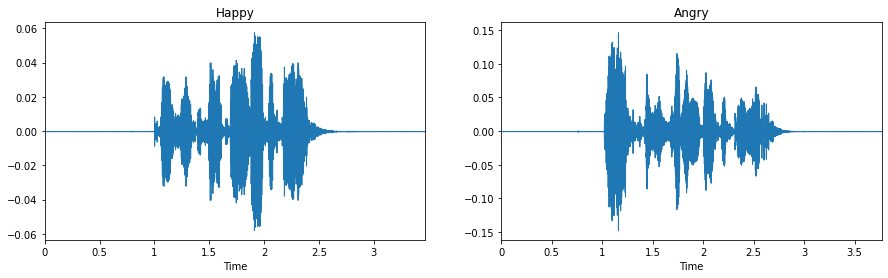

In [380]:
with soundfile.SoundFile('.\\RAVDESS dataset\\actor_01\\03-01-03-01-01-01-01.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Happy')

with soundfile.SoundFile('.\\RAVDESS dataset\\actor_02\\03-01-05-01-02-01-02.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 2, 2)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Angry')

Alright, there's a visible difference - but not enough to classify by emotion. Take my word for it. Try it if you like. However, [raw waveforms can be used](https://arxiv.org/abs/1712.00866) for certain other audio classification tasks with the right network. So, where do we get our features?
### Short-Time Fourier Transform (STFT)
The lowest-hanging fruit in time series signal processing is, of course, the Fourier Transform.
Specifically, we'll use the Short-time fourier transform (STFT) which will cut our audio waveform into short, overlapping equal length segments and
take the fourier transform of each segment individually to produce multiple power spectrograms, identifying resonant frequencies present in our audio file. <br>
<img src="img/stft.png" width=600 height=600 />

Let's start visualizing our features to get a better handle on them. <br>
Load a sample audio file from our dataset - each audio file is 3 seconds in length.

In [381]:
with soundfile.SoundFile('.\\RAVDESS dataset\\actor_01\\03-01-03-01-01-01-01.wav') as audio:
    happy_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

with soundfile.SoundFile('.\\RAVDESS dataset\\actor_02\\03-01-05-01-02-01-02.wav') as audio:
    angry_waveform = audio.read(dtype="float32")
    # same sample rate

##### Visualize the combination of power spectrograms output by STFT w.r.t time:

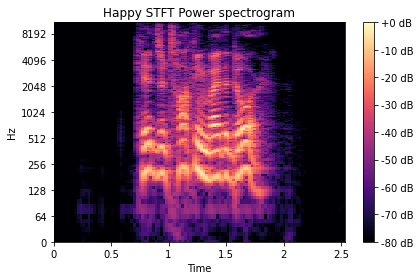

In [382]:
import numpy as np

stft_spectrum_matrix = librosa.stft(happy_waveform)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Happy STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

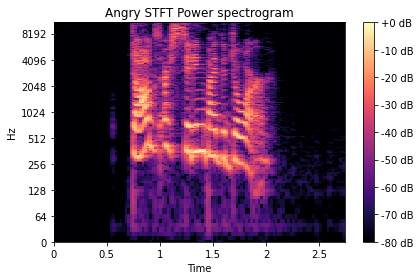

In [383]:
stft_spectrum_matrix = librosa.stft(angry_waveform)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Angry STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Now we're talking. Since we have a 3 second audio file, STFT spectrograms combine to show the change in frequency across a 3 second window.

### Mel Frequency Spectrograms, Cepstrums, and MFCC
We're going to build on the STFT and Mel Spectrograms by using the Mel Frequency Cepstral Coefficients (MFCCs) as a feature.
In brief, MFCC is a mathematical method which gives us coefficients representing amplitudes (in decibels) of pitch from a power spectrum (fourier frequency domain) of an audio signal.
In other words, MFC coefficients give us an idea of the audio intensity in various frequency (and so, pitch) regions. <br> <br>
To understound our major feature a little better, we should at least have a vague idea of the math behind it.
MFCC at its core uses STFT to produce audio power spectrums, which are then mapped to the "mel scale" -
a nonlinear pitch scale representing the perceived pitch (in "mels") of a sound signal w.r.t. its frequency, accounting for the way human
hearing perceives pitch based on frequency ratio rather than absolute differences in frequencies. This mapping of the frequency domain of an audio signal to the mel scale produces a mel spectrogram, and it is accomplished
by taking overlapping window functions - mel filterbanks, to be precise - applied to the power spectrum of an audio signal, giving us the sum of energy in each mel frequency filterbank (bin).

##### Visualize our sample's Mel spectrogram w.r.t time:

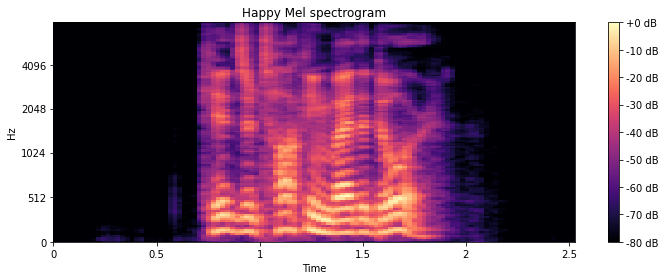

In [384]:
melspectrogram = librosa.feature.melspectrogram(y=happy_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.max),y_axis='mel',fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Happy Mel spectrogram')
plt.tight_layout()

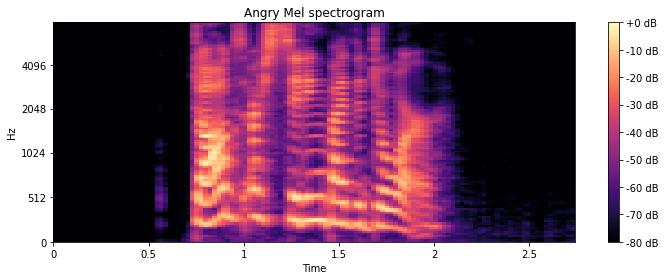

In [385]:
melspectrogram = librosa.feature.melspectrogram(y=angry_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.max),y_axis='mel',fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Angry Mel spectrogram')
plt.tight_layout()

Now we can take the log of the power  - the sum of energy in each mel frequency filterbank - and we produce a "cepstrum" in the "quefrency" domain, so confusingly named because we have
applied a transformation to an audio signal in its frequency domain, but have plotted it as a time series - not quite in the frequency domain, not quite in the time domain.
Finally, apply the discrete cosine transform (DCT) to the log of power in each filterbank.
Our MFC coefficients are then the amplitudes of each filterbank power (w.r.t. time) in our resulting cepstrum.
Another way to think about MFCC is as a deconvolution method to identify periodic (resonant) structures within an audio signal's frequency space.
We can visualize our MFC coefficients by plotting the coefficients provided by each mel filterbank against time.

###### Visualize our sample's MFC coefficients w.r.t time:

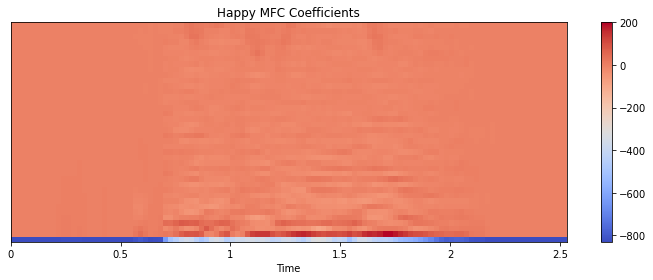

In [386]:
mfc_coefficients = librosa.feature.mfcc(y=happy_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time')
plt.colorbar()
plt.yticks
plt.title('Happy MFC Coefficients')
plt.tight_layout()

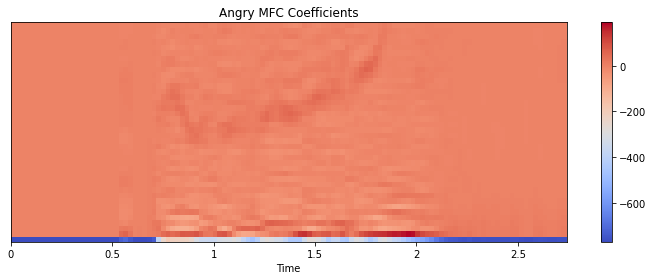

In [387]:
mfc_coefficients = librosa.feature.mfcc(y=angry_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time')
plt.colorbar()
plt.yticks
plt.title('Angry MFC Coefficients')
plt.tight_layout()

Not perfectly clear, but there is indeed a visible difference. Take note also of the difference in the scales to the right of the two plots.

##### Quick MFCC Derivation
1) Use the STFT to produce audio power spectrograms for short overlapping frames of the audio signal, <br>
2) Apply a mel-scale-based transformation, mel filterbanks (triangular window functions) to each STFT power spectrogram to produce mel spectrograms, <br>
3) Take the log of the sum of power of each mel filterbank in each mel spectrogram to produce mel-frequency cepstrums (the MFCs), <br>
4) Take the discrete cosine transform of the MFC of each frame, giving us the MFC coefficients - our measure of power at various mel frequencies (corresponding to pitches). <br>

Wikipedia has pretty straight-forward explanations of the [cepstrum](https://en.wikipedia.org/wiki/Cepstrum) and [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).
Below is an excellent visualization of the transformations between waveform, spectrogram, mel spectrogram, and MFCCs.
The vertical frame in each graph represents a single STFT frame.<br>
<img src="img/mfcc.gif" width=800 height=600/> <br>
### The Chromagram
To extract an additional feature, we're going to build a chromagram on each power spectrogram computed by STFT. A chromagram is a representation of an audio signal w.r.t. time, mapping audio signal to a pitch class.
Most often, we map to the 12 standard pitch classes (i.e. the musical scale CDEFGAB + 5 semitones gives us 12 pitch classes).
Again, wikipedia has a short and sweet [explanation](https://en.wikipedia.org/wiki/Chroma_feature). Below is a visualization of the relation between an audio waveform and its chromagram:

<img src="img/chromagram.png" width=500 height=500 />

##### Visualize the chromagram for our sample audio:

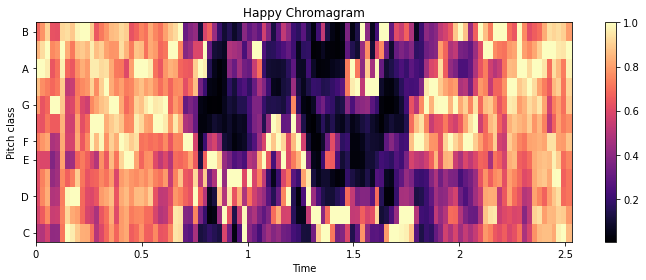

In [388]:
chromagram = librosa.feature.chroma_stft(y=happy_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Happy Chromagram')
plt.tight_layout()

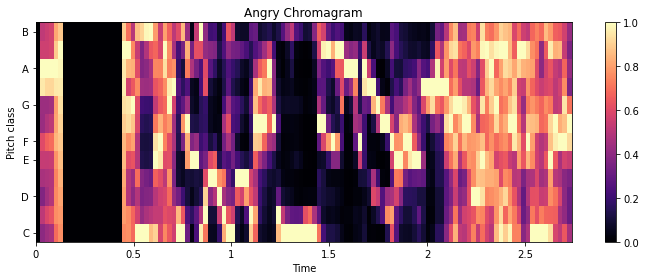

In [389]:
chromagram = librosa.feature.chroma_stft(y=angry_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Angry Chromagram')
plt.tight_layout()

We see the relative intensity of each pitch class in our audio files w.r.t time.

## Feature Extraction
We're going to take full advantage of librosa, a Python library enabling audio analysis and feature extraction. <br>
Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC. <br>
Although closely related, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features to try
and have bit more discriminatory power between samples. <br>
Let's build our feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files.

In [390]:
import librosa

def feature_chromagram(waveform, sample_rate):
    stft_spectrogram=np.abs(librosa.stft(waveform))
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

We're going to wrap our feature extraction functions so we only have to load each audio file once. After extracting our 3 audio features as NumPy arrays representing a time series, we're going to
stack them horizontally to create a single feature array.

In [391]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # return waveform
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        
        return feature_matrix

### Load the Dataset and Compute its Features
We have to understand the labelling of the RAVDESS dataset to find the ground truth emotion for each sample.
Each file is labelled with 7 numbers delimited by a "-"
Most of the numbers describe metadata about the audio file such as its format (video and/or audio),
whether the audio is a song or statement, which of two statements is being read and by which actor.
The third and fourth numbers pertain to the emotional quality.
The third number is in the range of 1-8 with each number representing an emotion.
The fourth number is either 1 or 2, representing normal (1) or strong (2) emotional intensity.

We're going to define a dictionary based on the third number (emotion) and assign an emotion to each number as specified by the RAVDESS dataset:

In [392]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

Finally, let's load our entire dataset and compute the features of each audio file:

In [393]:
import os, glob

def load_data():
    X,y=[],[]
    for file in glob.glob(".\\RAVDESS dataset\\actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        features=get_features(file)
        X.append(features)
        y.append(emotion)

    return np.array(X), y

Compute the feature matrix and read the emotion labels for the entire dataset.
Note that our regressor (independent/explanatory variable), usually denoted X, is named 'features', and our regressand (dependent varialbe), usually denoted y, is named 'emotions'.

In [394]:
features, emotions = load_data()

Let's see what the features we extracted look like:

In [ ]:
print(features[:5])
print(f'Audio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')

We have a matrix of dim 1440 x 180. Looks good - 1440 audio samples, one per row, with a series of
180 numerical features for each sample.

## Training an MLP Classifier on a Train/Test Split
We're going to first try a Multilayer Perceptron Classifier, a simple model suited for predictions trained on labelled inputs.
We'll use sklearn's train_test_split to create a standard 80/20 train/test split. The model is fit on 80% of
the data and scored - cross-validated - on 20% of the data, which it has never seen in training.

In [396]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

Initialize our MLP classifier. [Hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization) was done by Grid Search from sklearn.model_selection.GridSearchCV - better suited for a separate notebook.

In [397]:
model = MLPClassifier(
    activation='logistic', 
    solver='adam', 
    alpha=0.01, 
    batch_size=256, 
    epsilon=1e-08, 
    hidden_layer_sizes=(300,), 
    learning_rate='adaptive', 
    max_iter=500, 
    random_state=69)

X_train, X_test, y_train, y_test = train_test_split(features, emotions, test_size=0.2, random_state=69)
model.fit(X_train, y_train)

print(f'Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Model's accuracy on training set is 100.00%
Model's accuracy on test set is 68.40%


Not terrible, but not great either. Certainly better than guessing with a 1/8 (12.5%) chance. At any rate, our MLP model is not generalizing well to the test set.

### K-Fold Cross-Validation
To highlight the importance of cross-validation and get a better idea of our model's performance,
we're going to use K-Fold Cross-Validation (CV). We split our data set into K conecutive sets (folds).
We then use each set once as a test (validation) set, while the remaining K-1 sets form the training set to which our model is fit.
Note that while training sets overlap (unless otherwise defined, e.g. sklearn's GroupKFold), test sets never overlap.
We'll use 10-fold CV, with K=10 being a choice giving fairly low bias and moderate variance, meaning we will train our model on 10 training sets and check our model's accuracy on 10 testing sets.
Smaller datasets would better be scored with higher K, theoretically lowering bias to any one training set and giving a better estimate of the model's generalization at the cost of higher model variance.

Sine we're training a classifier, we use StratifiedKFold which preserves the percentage of samples in each class (emotion) for each fold. We also set shuffle=True to shuffle the order of in each fold since that's the default behaviour of sklearn's train_test_split. 

Choose K (n_splits) for our K-Fold CV and train the MLP classifier on each set of train/test folds.

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Convert list of emotions to array so it can be indexed for KFold CV
emotions = np.array(emotions)
kfold = StratifiedKFold(n_splits=10, random_state=69, shuffle=True)
scores = []
for train_indices, test_indices in kfold.split(features, emotions):
    # fit model to training fold
    model.fit(features[train_indices], emotions[train_indices])
    # score the model on test fold
    scores.append(model.score(features[test_indices], emotions[test_indices]))

print(f'KFold CV scores: {[100*score for score in scores]}')
print(f'Mean score of KFold CV: {100*np.mean(scores):.2f}% +-{100*np.std(scores):.2f}%')

Not much worse. If we were to get considerably worse performance fitting our model on random subsets of our training data, we could surmise that our model's performance is inflated by overfitting when we train it just once on 80% of the data and cross-validate on the remaining 20% of the data. However, that doesn't appear to be the case here. Let's dig a little deeper.

### The Validation Curve: Further Tuning of Hyperparameters

We can further check our model for overfitting dependedent on hyperparameters, and which value of what hyperparameter may be contributing to overfitting. We're going to use sklearn's validation_curve to check whether the hyperparameters alpha (L2 penalty for regularization) or epsilon (numerical stability in adam) could be better.

In [ ]:
## import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

# Build validation curve for 'alpha' hyperparameter
param_range = np.logspace(-10, -1, 5) # should encompass relevant values for both alpha and epsilon
train_scores, test_scores = validation_curve(
    model, X=X_test, 
    y=y_test, 
    param_name="alpha", 
    param_range=param_range,
    scoring="accuracy", 
    n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Build validation curve for 'epsilon' hypermarameter
train_scores2, test_scores2 = validation_curve(
    model, X=X_test, 
    y=y_test, 
    param_name="epsilon", 
    param_range=param_range,
    scoring="accuracy", 
    n_jobs=1)
train_scores_mean2 = np.mean(train_scores2, axis=1)
train_scores_std2 = np.std(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
test_scores_std2 = np.std(test_scores2, axis=1)

# Plot validation curve for alpha
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Validation Curve for alpha")
plt.xlabel(r"$\alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
linewidth = 2
# Plot alpha train scores
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=linewidth)
# Plot error window for alpha train scores
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=linewidth)
# Plot alpha test scores
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=linewidth)
# Plot error window for alpha test scores
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=linewidth)

# Plot validation curve for epsilon
plt.subplot(1,2,2)
plt.subplots_adjust(hspace=0.5)
plt.title("Validation Curve for epsilon")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
# Plot epsilon train scores
plt.semilogx(param_range, train_scores_mean2, label="Training score",
             color="darkorange", lw=linewidth)
# Plot error window for epsilon train scores
plt.fill_between(param_range, train_scores_mean2 - train_scores_std2,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=linewidth)
# Plot epsilon test scores
plt.semilogx(param_range, test_scores_mean2, label="Cross-validation score",
             color="navy", lw=linewidth)
# Plot error window for epsilon test scores
plt.fill_between(param_range, test_scores_mean2 - test_scores_std2,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=linewidth)
plt.legend(loc="best")
plt.show()

Nope - Grid Search did well for us. Our hyperparameters are just fine where they are and in fact don't make much of a difference within a reasonable range. Since deep learning methods notoriously work better (absolutely require) large datasets, let's check if the size of our data set might the problem.

### The Learning Curve: Determining Optimal Training Set Size

In [ ]:
from sklearn.model_selection import learning_curve

# Plot test scores
train_sizes, train_scores, test_scores = learning_curve(
    model, 
    X=features, 
    y=emotions, 
    cv=5, n_jobs=1, 
    train_sizes=[80,100,110,200,400,600,1000,1100])

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()

The learning curve tells us that the size of the dataset isn't our issue - our accuracy wouldn't benefit from a larger training set. It has become clear that the MLPClassifier isn't the right choice of model - it seems to not have the complexity we would need to accurately discriminate the differences between our features w.r.t. emotion. We would need a considerably more sophisticated deep neural net to get better performance on this dataset.

## Alternative Models
#### Linear model: Support Vector Classifier
An argument can be made to use classic machine learning due to the small size of our data set. 
We can give this a quick test with a support vector machine based classifier - SVC - a linear model performing well on small datasets compared to other machine learning methods. 

In [ ]:
from sklearn.svm import LinearSVC

model= LinearSVC(
    penalty='l2',
    loss='hinge', 
    C=10, 
    random_state=69)

X_train, X_test, y_train, y_test = train_test_split(features, emotions, test_size=0.2, random_state=69)
model.fit(X_train, y_train)

print(f'Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

scores = []
for train_indices, test_indices in kfold.split(features, emotions):
    # fit model to training fold
    model.fit(features[train_indices], emotions[train_indices])
    # score the model on test fold
    scores.append(model.score(features[test_indices], emotions[test_indices]))

print(f'KFold CV scores: {[100*score for score in scores]}')
print(f'Mean score of KFold CV: {100*np.mean(scores):.2f}% +-{100*np.std(scores):.2f}%')

Not good at all. It's worth noting that the SVC model takes considerably less time to train than an MLP Classifier, largely due to the small size of our data set. The time to fit an SVC model is quadratic while fitting an MLP Classifier has a significantly higher complexity, exponential w.r.t. number of hiddden layers due to its use of backpropogation. Unfortunately, SVC does help us better classify the emotions of speech. 

#### Non-Linear Decision Tree Ensemble Model: Random Forest 
Before resorting to more complex deep learning methods, let's try a Random Forest - a good model to use as a benchmark due to the low time complexity to train it and because it is an ensemble method, its robustness to different distributions and outliers in the data set means Random Forests require relatively little exploratory analysis.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model= RandomForestClassifier(
    n_estimators = 100, 
    max_depth = 10, 
    criterion='gini', 
    random_state=69)

X_train, X_test, y_train, y_test = train_test_split(features, emotions, test_size=0.2, random_state=69)
model.fit(X_train, y_train)

print(f'Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')\

scores = []
for train_indices, test_indices in kfold.split(features, emotions):
    # fit model to training fold
    model.fit(features[train_indices], emotions[train_indices])
    # score the model on test fold
    scores.append(model.score(features[test_indices], emotions[test_indices]))

print(f'KFold CV scores: {[100*score for score in scores]}')
print(f'Mean score of KFold CV: {100*np.mean(scores):.2f}% +-{100*np.std(scores):.2f}%')

Nice - nearly the same test accuracy as the MLP Classifier at a fraction of the cost to train at a low tree depth of 10.
However, it's clear that we're going to need to pull out the big guns if we want to seriously improve our model's test score and get good generalizability out of it.

## Conclusion

The MLPClassifier is powerful in that it achieves appreciable performance with relatively little effort invested in exploratory analysis, hyperparameter optimization, and model architechture. We're going to have to explore more complicated deep learning methods to get real performance on this data set. In the next notebook I'm going to explore LSTM RNNs and CNNs for this task.

If you got this far, you're an ace in my book. 